<a href="https://colab.research.google.com/github/NavdeeepSinghh/Data-Generation-using-Modelling-and-Simulation-for-ML/blob/main/Untitled26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pybullet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.7-cp312-cp312-linux_x86_64.whl size=99873154 sha256=6c85d6bbd87aca35a4698c8e14ce95ba7df9910fd5e5dd0aadf23e68d17718d0
  Stored in directory: /root/.cache/pip/wheels/72/95/1d/b336e5ee612ae9a019bfff4dc0bedd100ee6f0570db205fdf8
Successfully built pybullet


In [3]:
import pybullet as p
import pybullet_data
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [4]:
def run_simulation(mass, friction, restitution, height, gravity):
    p.connect(p.DIRECT)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.resetSimulation()
    p.setGravity(0, 0, -gravity)

    plane_id = p.loadURDF("plane.urdf")

    collision_shape = p.createCollisionShape(
        shapeType=p.GEOM_BOX,
        halfExtents=[0.1, 0.1, 0.1]
    )

    visual_shape = p.createVisualShape(
        shapeType=p.GEOM_BOX,
        halfExtents=[0.1, 0.1, 0.1]
    )

    cube_id = p.createMultiBody(
        baseMass=mass,
        baseCollisionShapeIndex=collision_shape,
        baseVisualShapeIndex=visual_shape,
        basePosition=[0, 0, height]
    )

    p.changeDynamics(cube_id, -1, lateralFriction=friction, restitution=restitution)

    initial_energy = mass * gravity * height

    for _ in range(240 * 3):
        p.stepSimulation()

    final_pos, final_orn = p.getBasePositionAndOrientation(cube_id)
    final_energy = mass * gravity * final_pos[2]

    p.disconnect()

    energy_loss = initial_energy - final_energy
    return energy_loss

In [5]:
data = []

for _ in range(1000):
    mass = random.uniform(0.5, 5.0)
    friction = random.uniform(0.1, 1.0)
    restitution = random.uniform(0.0, 0.9)
    height = random.uniform(0.5, 5.0)
    gravity = random.uniform(5, 15)

    energy_loss = run_simulation(mass, friction, restitution, height, gravity)

    data.append([mass, friction, restitution, height, gravity, energy_loss])

df = pd.DataFrame(
    data,
    columns=["mass", "friction", "restitution", "height", "gravity", "energy_loss"]
)

df.head()

,mass,friction,restitution,height,gravity,energy_loss
0,0.983568,0.642899,0.342243,2.847749,9.177468,24.803117
1,0.880325,0.872993,0.732632,3.138605,5.510989,14.741738
2,2.625845,0.359133,0.673132,1.919151,12.358335,59.033785
3,2.085946,0.612524,0.215572,2.518819,12.365254,62.389497
4,2.357643,0.811199,0.005222,0.665192,14.370049,19.148780


In [6]:
df.to_csv("pybullet_simulation_data.csv", index=False)
print("Dataset saved!")

Dataset saved!


In [7]:
X = df.drop("energy_loss", axis=1)
y = df["energy_loss"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

In [9]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(
    results, columns=["Model", "MAE", "RMSE", "R2 Score"]
)

results_df.sort_values("RMSE")

,Model,MAE,RMSE,R2 Score
4,Random Forest,4.266542,6.404190,0.986775
5,Gradient Boosting,4.762162,6.790592,0.985131
3,Decision Tree,7.666631,10.931862,0.961465
2,Lasso Regression,15.397045,20.844975,0.859891
1,Ridge Regression,15.504339,20.915257,0.858944
0,Linear Regression,15.507353,20.916534,0.858927
6,SVR,23.819094,36.856070,0.561991


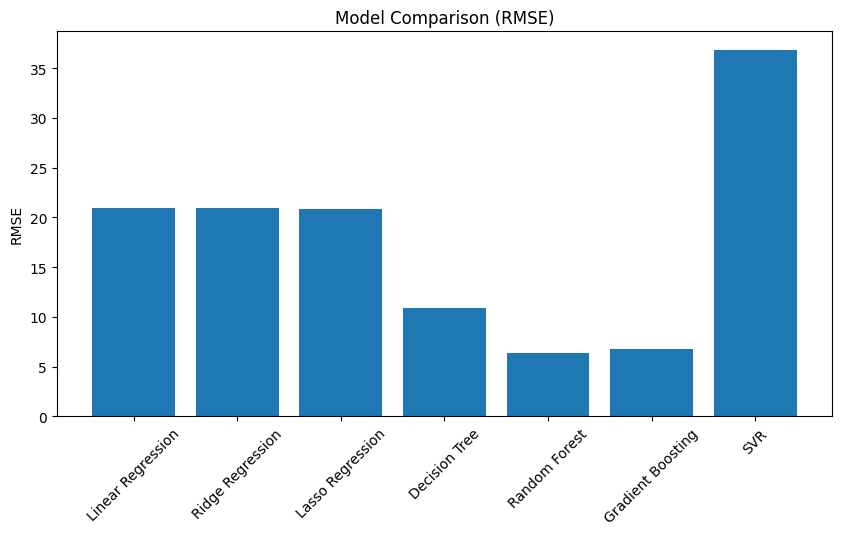

In [10]:
plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("Model Comparison (RMSE)")
plt.show()

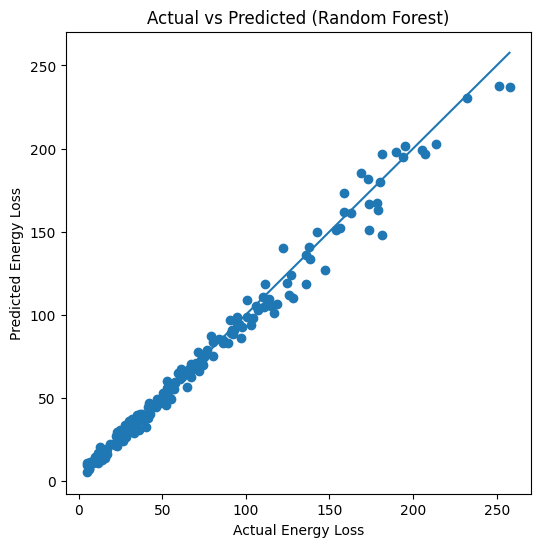

In [11]:
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds)
plt.xlabel("Actual Energy Loss")
plt.ylabel("Predicted Energy Loss")
plt.title("Actual vs Predicted (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()

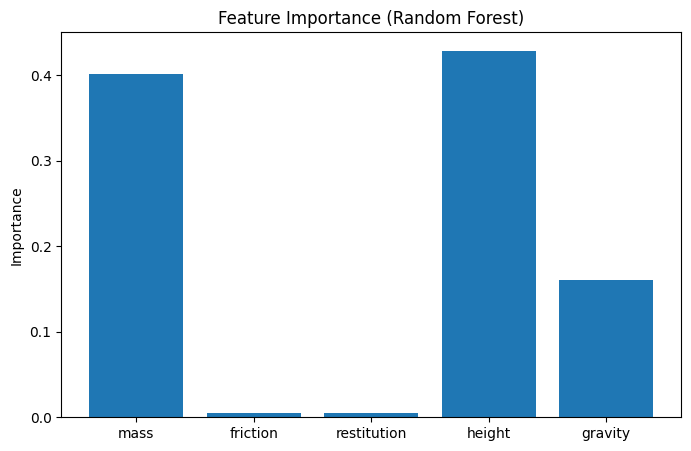

In [12]:
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.bar(features, importances)
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()